In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# Text Processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
MBTI_DS = pd.read_csv("E:\mbti\mbti_1.csv")
MBTI_DS.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [4]:
MBTI_DS.isnull().any()

type     False
posts    False
dtype: bool

In [5]:
nRow, nCol = MBTI_DS.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


In [6]:
MBTI_DS.dtypes

type     object
posts    object
dtype: object

In [7]:
MBTI_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


SUMMARY
- JUST 2 columns in MBTI DATASET
- Number rows IS 8675
- No null valuesin MBTI DATASET
- -All values are textual, So we should convert to numeric form to train the Machine Learning model

In [8]:
MBTI_DS.describe(include=['object'])

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


We see There are 16 unique personality type indicators in the dataset INFP most frequently occuring personality type

Number of occurences is 1832

In [9]:
types = np.unique(np.array(MBTI_DS['type']))
print("The Unique values 'type' of personality column",types)

The Unique values 'type' of personality column ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [10]:
#Finding the most common words in all posts.
words = list(MBTI_DS["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546),
 ('when', 34389),
 ('would', 32605),
 ('really', 31369),
 ('all', 31344),
 ('more', 31188),
 ('know', 31130),
 ('they', 29386),
 ('get', 28948),
 ('because', 27438),
 ('am', 27109)]

The posts contain general words like : I, to, the, a, and, of, is, you etc.

we assume that these words don't really provide any useful information to train the Machine Learning model as most of them are stop-words or other useless words.

WORDCLOUD

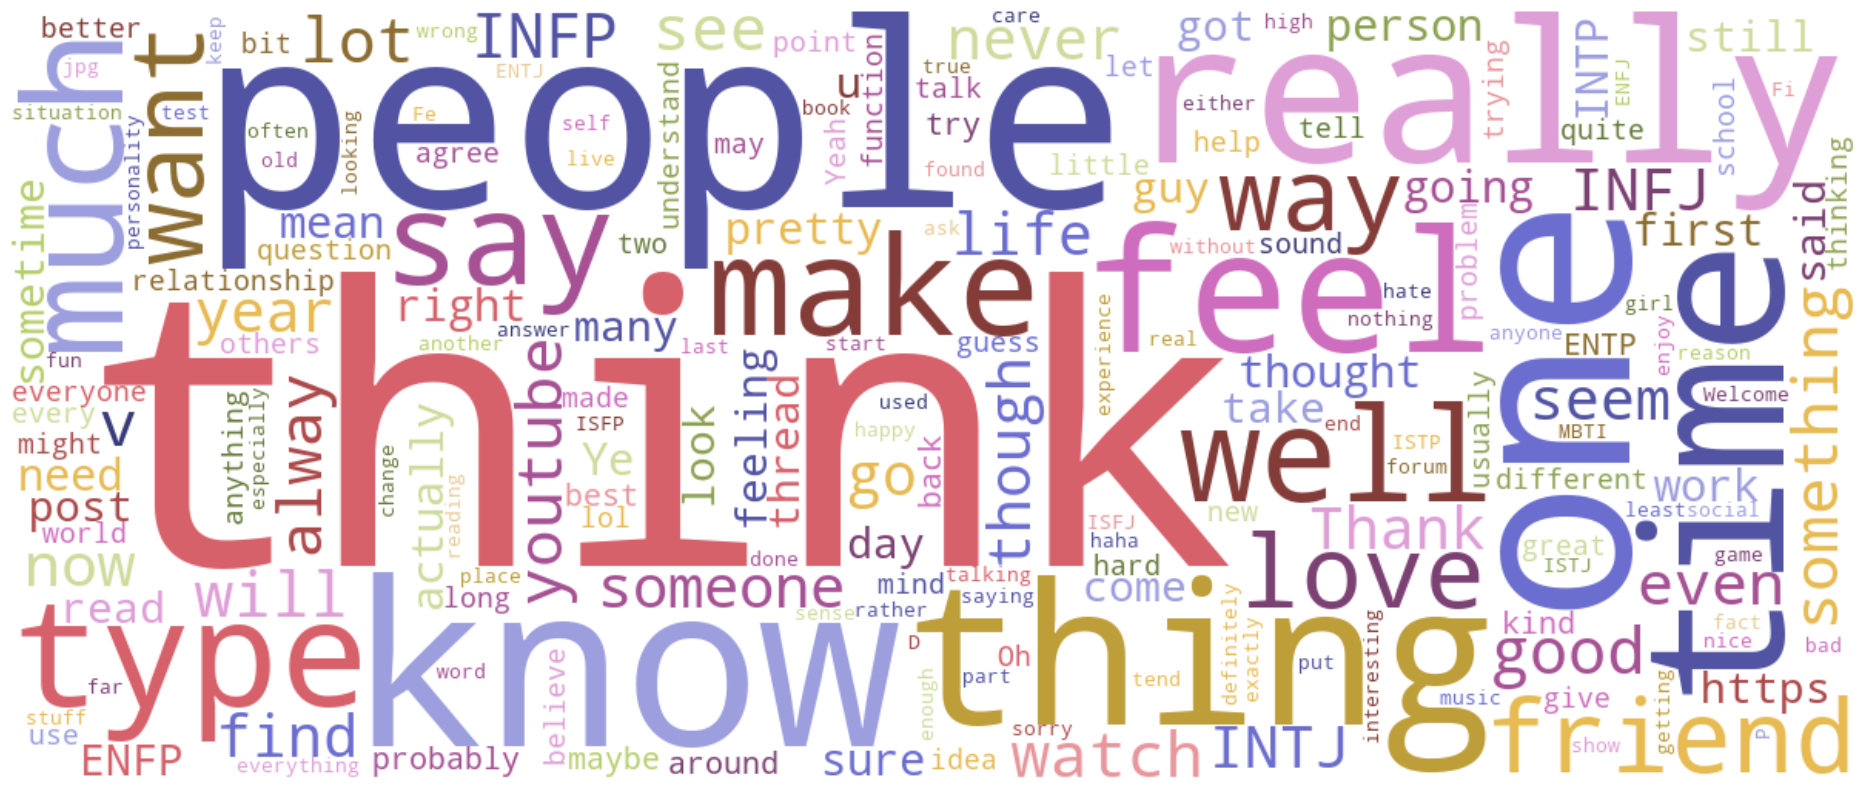

In [11]:
wc = wordcloud.WordCloud(width=1200, height=500, collocations=False, background_color="white", colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

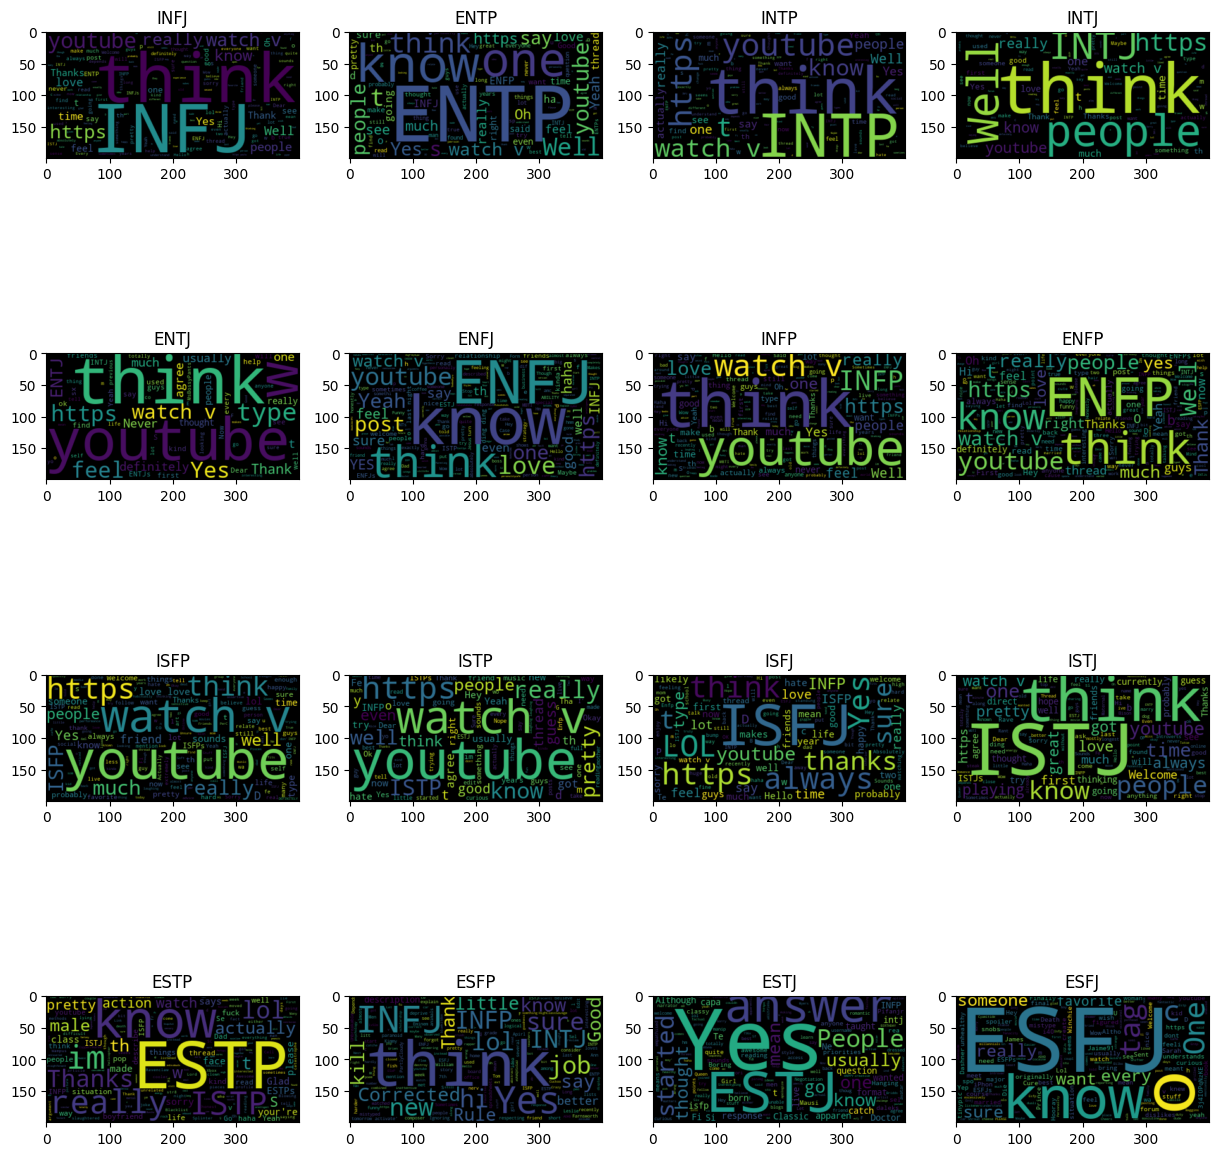

In [12]:
fig, ax = plt.subplots(len(MBTI_DS['type'].unique()), figsize=(15,len(MBTI_DS['type'].unique())))
k = 0
for i in MBTI_DS['type'].unique():
    df_4 = MBTI_DS[MBTI_DS['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

we can see there are a number of irrelevant words present in the dataset (e.g. ha, ar, Ti etx.) which will need to be removed Interestingly, among the most common words in the word clouds of individual personality types, is the names of MBTI personlity types themselves. It would hence be necessary to clean our posts by removing these MBTI words from each of them as part of our pre-processing stage, before training the model for better evaluation results.

In [13]:
#add columns for personality type indicators

def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

MBTI_DS_N = MBTI_DS.join(MBTI_DS.apply (lambda row: get_types (row),axis=1))
MBTI_DS_N.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


The above code assigns a value of 1 to individuals who possess the traits of Introversion (I), Intuition (N), Thinking (T), and Judging (J) on the four axes of the Myers-Briggs Type Indicator (MBTI) - Introversion-Extraversion (IE), Intuition-Sensing (NS), Feeling-Thinking (FT), and Judging-Perceiving (JP). All other individuals are assigned a value of 0.

This allows us to calculate the number of posts that correspond to introverted individuals versus extroverted individuals out of all the entries in the labeled Kaggle dataset. This analysis is conducted to examine the dataset for each individual personality index of the MBTI.

In [14]:
#Counting Number posts in one class | Total Number posts in other class

print ("Introversion (I) |  Extroversion (E): \t", MBTI_DS_N['IE'].value_counts()[0], " | ", MBTI_DS_N['IE'].value_counts()[1])
print ("Intuition    (N) |  Sensing      (S): \t", MBTI_DS_N['NS'].value_counts()[0], " | ", MBTI_DS_N['NS'].value_counts()[1])
print ("Thinking     (T) |  Feeling      (F): \t", MBTI_DS_N['TF'].value_counts()[0], " | ", MBTI_DS_N['TF'].value_counts()[1])
print ("Judging      (J) |  Perceiving   (P): \t", MBTI_DS_N['JP'].value_counts()[0], " | ", MBTI_DS_N['JP'].value_counts()[1])

Introversion (I) |  Extroversion (E): 	 1999  |  6676
Intuition    (N) |  Sensing      (S): 	 1197  |  7478
Thinking     (T) |  Feeling      (F): 	 4694  |  3981
Judging      (J) |  Perceiving   (P): 	 5241  |  3434


We can see that there is an uneven distribution of the entries in our dataset across the four axes of the MBTI, with E being the majority in the IE axis, S being the majority in the NS axis, and relatively less difference between T and F in the TF axis, and J and P in the JP axis.

From this heatmap also, it is unclear if it shows anything valuable for interpretation

SUMMARY We notice that there are a number of irrelevant words present in the dataset, such as "ha," "ar," and "Ti," which need to be removed. Additionally, we observe that among the most frequent words in the word clouds of individual personality types, are the names of the MBTI personality types themselves. Therefore, it is important to clean the posts by removing these MBTI words from each of them as part of the pre-processing stage before training the model to achieve better evaluation results.

Pre-Processing Stage

We preprocess the posts by using Lemmatization technique. Lemmatization groups together different inflected forms of a word so they can be analyzed as a single item. Unlike stemming, lemmatization takes into account the context of the word, making it a more suitable choice for our model. This technique links words with similar meanings to one word, resulting in a more accurate analysis.

In [15]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP','ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

Binarizing the each personality type feature

In [16]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

#Show result output for personality prediction
def translate_back(personality):
    # transform binary vector to MBTI personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in MBTI_DS_N.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


Cleaning Data in posts

In [17]:
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [18]:
import nltk
nltk.download("wordnet")

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [19]:
def pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_MBTI_DS_N = len(MBTI_DS_N)
  i=0
  
  for row in MBTI_DS_N.iterrows():
      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", MBTI_DS_N.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", MBTI_DS_N.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [20]:
nRow, nCol = list_personality.shape
print(f'Number of posts = {nRow}  and No. of Personalities = {nCol} ')

Number of posts = 8675  and No. of Personalities = 4 


Feature Engineering - TF-IDF

In our model, we use Tf-idf feature engineering to determine the relevance and importance of a word in relation to a document within a collection of documents. This technique is particularly useful for training individual classifiers and scoring words in machine learning algorithms for natural language processing. We vectorize the dataset using both count vectorizer and tf-idf vectorizer, while only keeping words that appear between 10-70% of the posts.

In [21]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 

# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


Therefore we now have 595 features for each user post.

Splitting into X and Y variable

linkcode Hence we split the features as :

X: User Posts in TF-IDF representation

Y: Personality type in Binarized MBTI form

In [22]:
personality_type = [ "IE: Introversion (I) | Extroversion (E)", "NS: Intuition    (N) | Sensing      (S)", 
                   "FT: Feeling      (F) | Thinking     (T)", "JP: Judging      (J) | Perceiving   (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) | Extroversion (E)
NS: Intuition    (N) | Sensing      (S)
FT: Feeling      (F) | Thinking     (T)
JP: Judging      (J) | Perceiving   (P)


Let's see how the posts look in TF-IDF representation: (we have taken 1st post for demonstration)

In [23]:
print("X: First post in tf-idf representation\n%s" % X_tfidf[0])

X: First post in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08105478 0.07066064
 0.         0.         0.         0.         0.         0.
 0.         0.04516864 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05321691 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0871647  0.         0.         0.
 0.         0.         0.         0.05506308 0.0708757  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16585935 0.         0.         0.09676192 0.
 0.         0.04970682 0.         0.         0.         0.
 0.07397056 0.         0.         0.         0.         0.
 0.      

In [24]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


Therefore we have successfully converted the textual data into numerical form

Training & Evaluating Models

In [25]:
X = X_tfidf
Y = list_personality[:,l]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [26]:
# Logistic
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train,model.predict(X_train)))
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    print("\n")

IE: Introversion (I) | Extroversion (E) Accuracy: 77.54%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.79      0.99      0.87      4447
           1       0.73      0.12      0.21      1365

    accuracy                           0.78      5812
   macro avg       0.76      0.55      0.54      5812
weighted avg       0.77      0.78      0.72      5812

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2229
           1       0.46      0.08      0.14       634

    accuracy                           0.78      2863
   macro avg       0.62      0.53      0.50      2863
weighted avg       0.72      0.78      0.71      2863



NS: Intuition    (N) | Sensing      (S) Accuracy: 86.06%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data


logistic regression准确率：
IE:77.54%
NS:86.06%
FT:72.44%
JP:64.51%


K-value: 1

K-Nearest Neighbors - Train Confusion Matrix
 Predicted     0     1
Actual               
0          2291    24
1             0  3497

K-Nearest Neighbors - Train accuracy: 0.996

K-Nearest Neighbors - Train Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2315
           1       0.99      1.00      1.00      3497

    accuracy                           1.00      5812
   macro avg       1.00      0.99      1.00      5812
weighted avg       1.00      1.00      1.00      5812



K-Nearest Neighbors - Test Confusion Matrix
 Predicted    0     1
Actual              
0           91  1028
1          100  1644

K-Nearest Neighbors - Test accuracy: 0.606

K-Nearest Neighbors - Test Classification Report
               precision    recall  f1-score   support

           0       0.48      0.08      0.14      1119
           1       0.62      0.94      0.74      1744

    accuracy                           

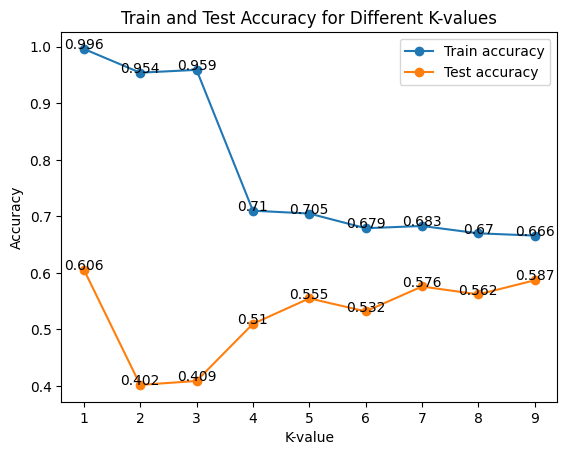

In [28]:
#KNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define a range of K values to test
k_vals = range(1, 10)  # You can change the range to any desired range of K values

# Initialize an empty array to store results
dummyarray = np.empty((len(k_vals), 3))
k_valchart = pd.DataFrame(dummyarray, columns=["K_value", "Train_acc", "Test_acc"])

# Loop through each K value and fit the model
for i, k in enumerate(k_vals):
    knn_fit = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn_fit.fit(X_train, y_train)  # Fit the model on the training data

    # Train accuracy
    tr_accscore = round(accuracy_score(y_train, knn_fit.predict(X_train)), 3)
    print(f"\nK-value: {k}")
    print("\nK-Nearest Neighbors - Train Confusion Matrix\n", pd.crosstab(y_train, knn_fit.predict(X_train), rownames=["Actual"], colnames=["Predicted"]))
    print(f"\nK-Nearest Neighbors - Train accuracy: {tr_accscore}")
    print("\nK-Nearest Neighbors - Train Classification Report\n", classification_report(y_train, knn_fit.predict(X_train)))

    # Test accuracy
    ts_accscore = round(accuracy_score(y_test, knn_fit.predict(X_test)), 3)
    print("\n\nK-Nearest Neighbors - Test Confusion Matrix\n", pd.crosstab(y_test, knn_fit.predict(X_test), rownames=["Actual"], colnames=["Predicted"]))
    print(f"\nK-Nearest Neighbors - Test accuracy: {ts_accscore}")
    print("\nK-Nearest Neighbors - Test Classification Report\n", classification_report(y_test, knn_fit.predict(X_test)))

    # Store the results
    k_valchart.loc[i, 'K_value'] = k
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = ts_accscore

# Plot the train and test accuracy scores for different K-values
plt.plot(k_valchart['K_value'], k_valchart['Train_acc'], label='Train accuracy', marker='o')
plt.plot(k_valchart['K_value'], k_valchart['Test_acc'], label='Test accuracy', marker='o')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.xticks(k_valchart['K_value'])
plt.title('Train and Test Accuracy for Different K-values')

# Annotate points on the plot
for a, b in zip(k_valchart["K_value"], k_valchart["Train_acc"]):
    plt.text(a, b, str(b), fontsize=10, ha='center')
for a, b in zip(k_valchart["K_value"], k_valchart["Test_acc"]):
    plt.text(a, b, str(b), fontsize=10, ha='center')

# Show legend and plot
plt.legend()
plt.show()

logistic regression准确率：
IE:77.54%
NS:86.06%
FT:72.44%
JP:64.51%
KNN总体准确率：
k=1~4不平稳，k>4后准确率在62%左右

In [29]:
#XGBoost
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train,model.predict(X_train)))
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    print("\n")

IE: Introversion (I) | Extroversion (E) Accuracy: 76.18%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4447
           1       1.00      0.94      0.97      1365

    accuracy                           0.99      5812
   macro avg       0.99      0.97      0.98      5812
weighted avg       0.99      0.99      0.99      5812

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2229
           1       0.37      0.11      0.17       634

    accuracy                           0.76      2863
   macro avg       0.58      0.53      0.51      2863
weighted avg       0.70      0.76      0.71      2863



NS: Intuition    (N) | Sensing      (S) Accuracy: 85.37%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data


logistic regression准确率：
IE:77.54%
NS:86.06%
FT:72.44%
JP:64.51%

KNN总体准确率：
k=1~4不平稳，k>4后准确率在62%左右

XGboost准确率：
IE:76.18%
NS:85.37%
FT:67.73%
JP:62.84%

In [30]:
# SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Fit model on training data using SVM
    model = SVC(kernel='linear')  # You can change kernel to 'rbf', 'poly', etc. for non-linear SVMs
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    
    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train, model.predict(X_train)))

    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))

    # Print out additional parameters (you can add more parameters based on your needs)
    print(f"{personality_type[l]} SVM Model Parameters:")
    print(f"  Support vectors: {model.support_}")
    print(f"  Number of support vectors for each class: {model.n_support_}")
    print(f"  Support vector coefficients: {model.dual_coef_}")
    print(f"  Intercept: {model.intercept_}")
    print(f"  Kernel: {model.kernel}")
    print(f"  C parameter: {model.C}")
    print(f"  Gamma: {model.gamma}")
    
    print("\n")


IE: Introversion (I) | Extroversion (E) Accuracy: 77.89%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4447
           1       0.00      0.00      0.00      1365

    accuracy                           0.77      5812
   macro avg       0.38      0.50      0.43      5812
weighted avg       0.59      0.77      0.66      5812

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2229
           1       1.00      0.00      0.00       634

    accuracy                           0.78      2863
   macro avg       0.89      0.50      0.44      2863
weighted avg       0.83      0.78      0.68      2863

IE: Introversion (I) | Extroversion (E) SVM Model Parameters:
  Support vectors: [   2   11   13 ... 5787 5788 5801]
  Number of support

logistic regression准确率：
IE:77.54%
NS:86.06%
FT:72.44%
JP:64.51%

KNN总体准确率：
k=1~4不平稳，k>4后准确率在62%左右

XGboost准确率：
IE:76.18%
NS:85.37%
FT:67.73%
JP:62.84%

SVM准确率：
IE:77.89%
NS:86.03%
FT:72.86%
JP:62.9%

IE: Introversion (I) | Extroversion (E) Voting Classifier Accuracy: 76.14%
IE: Introversion (I) | Extroversion (E) Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4447
           1       0.80      0.38      0.52      1365

    accuracy                           0.83      5812
   macro avg       0.82      0.68      0.71      5812
weighted avg       0.83      0.83      0.81      5812

IE: Introversion (I) | Extroversion (E) Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2229
           1       0.40      0.16      0.23       634

    accuracy                           0.76      2863
   macro avg       0.60      0.55      0.54      2863
weighted avg       0.71      0.76      0.72      2863

IE: Introversion (I) | Extroversion (E) Voting Model Parameters:
  Base models: SVM, Random Forest, Logistic Regress

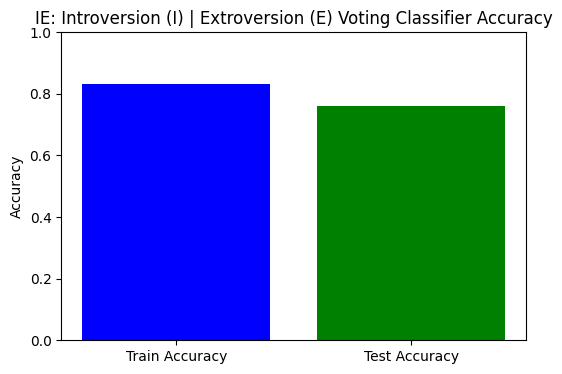



NS: Intuition    (N) | Sensing      (S) Voting Classifier Accuracy: 86.03%
NS: Intuition    (N) | Sensing      (S) Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5015
           1       1.00      0.19      0.32       797

    accuracy                           0.89      5812
   macro avg       0.94      0.60      0.63      5812
weighted avg       0.90      0.89      0.85      5812

NS: Intuition    (N) | Sensing      (S) Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2463
           1       0.00      0.00      0.00       400

    accuracy                           0.86      2863
   macro avg       0.43      0.50      0.46      2863
weighted avg       0.74      0.86      0.80      2863

NS: Intuition    (N) | Sensing      (S) Voting Model Parameters:
  Base models: SVM, Random Forest, Logistic Regre

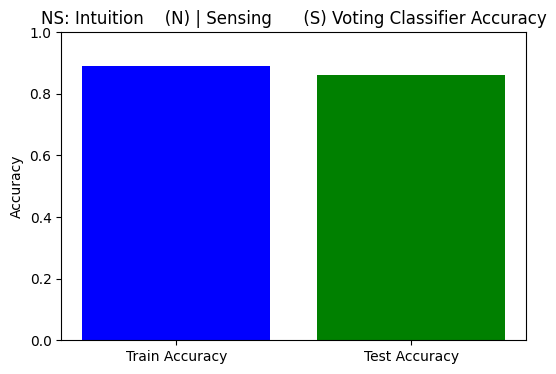



FT: Feeling      (F) | Thinking     (T) Voting Classifier Accuracy: 71.57%
FT: Feeling      (F) | Thinking     (T) Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3140
           1       0.81      0.78      0.80      2672

    accuracy                           0.82      5812
   macro avg       0.81      0.81      0.81      5812
weighted avg       0.82      0.82      0.81      5812

FT: Feeling      (F) | Thinking     (T) Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1554
           1       0.70      0.66      0.68      1309

    accuracy                           0.72      2863
   macro avg       0.71      0.71      0.71      2863
weighted avg       0.71      0.72      0.71      2863

FT: Feeling      (F) | Thinking     (T) Voting Model Parameters:
  Base models: SVM, Random Forest, Logistic Regre

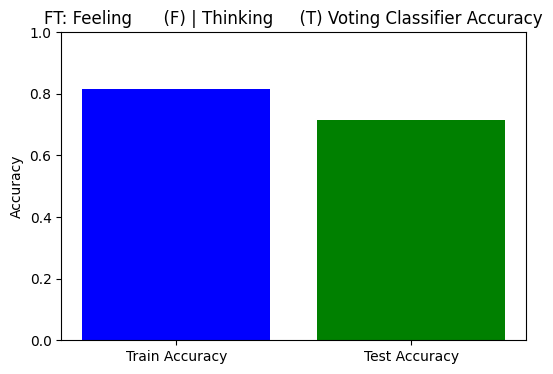



JP: Judging      (J) | Perceiving   (P) Voting Classifier Accuracy: 63.19%
JP: Judging      (J) | Perceiving   (P) Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      2315
           1       0.75      0.86      0.80      3497

    accuracy                           0.75      5812
   macro avg       0.74      0.72      0.72      5812
weighted avg       0.74      0.75      0.74      5812

JP: Judging      (J) | Perceiving   (P) Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.54      0.39      0.45      1119
           1       0.67      0.79      0.72      1744

    accuracy                           0.63      2863
   macro avg       0.60      0.59      0.59      2863
weighted avg       0.62      0.63      0.62      2863

JP: Judging      (J) | Perceiving   (P) Voting Model Parameters:
  Base models: SVM, Random Forest, Logistic Regre

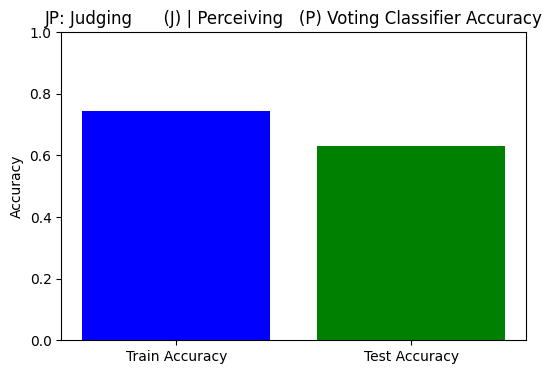

In [32]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# 假设 list_personality 是一个二维数组，每列是一个性格类型的标签，X 是特征数据
# personality_type = ['INTJ', 'ENTP', 'ISFP', ...]  # 这里是示例，可以根据实际情况调整

for l in range(len(personality_type)):  # 迭代每个MBTI类型

    # 获取目标变量
    Y = list_personality[:, l]

    # 切分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # 数据标准化（适用于SVM和LR）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 定义基础模型
    svm_model = SVC(kernel='linear', random_state=7)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)
    lr_model = LogisticRegression(max_iter=1000, random_state=7)

    # 定义VotingClassifier，结合三个模型
    voting_model = VotingClassifier(
        estimators=[('svm', svm_model), ('rf', rf_model), ('lr', lr_model)],
        voting='hard'  # 硬投票（根据多数投票决策）
    )

    # 训练Voting模型
    voting_model.fit(X_train_scaled, y_train)

    # 对测试集进行预测
    y_pred = voting_model.predict(X_test_scaled)

    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{personality_type[l]} Voting Classifier Accuracy: {accuracy * 100.0:.2f}%")

    # 输出训练和测试集的分类报告
    print(f"{personality_type[l]} Classification Report for Train Data:")
    print(classification_report(y_train, voting_model.predict(X_train_scaled)))

    print(f"{personality_type[l]} Classification Report for Test Data:")
    print(classification_report(y_test, y_pred))

    # 输出Voting模型参数
    print(f"{personality_type[l]} Voting Model Parameters:")
    print(f"  Base models: SVM, Random Forest, Logistic Regression")
    print(f"  Voting type: Hard Voting (Majority Voting)")

    # 可视化模型准确率
    # 这里简单的绘制一个柱状图，比较训练集与测试集的准确率
    accuracy_train = accuracy_score(y_train, voting_model.predict(X_train_scaled))
    accuracy_test = accuracy

    # 绘制图形
    plt.figure(figsize=(6, 4))
    plt.bar(['Train Accuracy', 'Test Accuracy'], [accuracy_train, accuracy_test], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title(f"{personality_type[l]} Voting Classifier Accuracy")
    plt.ylabel("Accuracy")
    plt.show()

    print("\n")


Epoch 1/3
182/182 [==============================] - 1s 3ms/step - loss: 0.5498 - accuracy: 0.7591 - val_loss: 0.5144 - val_accuracy: 0.7786
Epoch 2/3
182/182 [==============================] - 0s 2ms/step - loss: 0.5195 - accuracy: 0.7651 - val_loss: 0.4952 - val_accuracy: 0.7786
Epoch 3/3
90/90 [==============================] - 0s 1ms/step
IE: Introversion (I) | Extroversion (E) Accuracy: 77.93%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
182/182 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4447
           1       1.00      0.01      0.01      1365

    accuracy                           0.77      5812
   macro avg       0.88      0.50      0.44      5812
weighted avg       0.82      0.77      0.67      5812

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

        

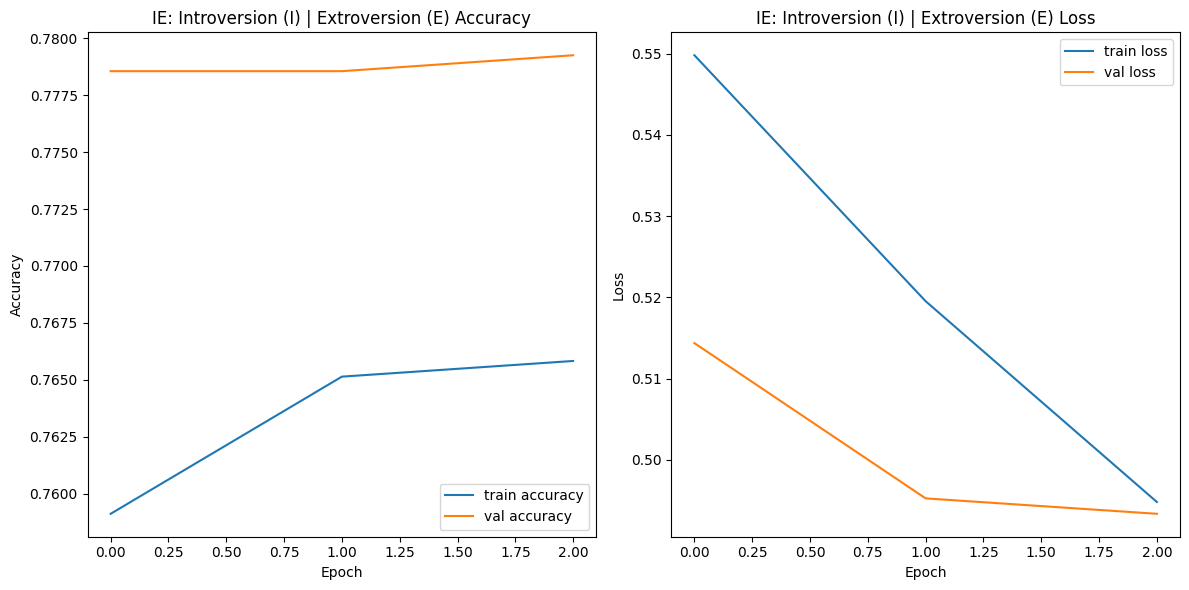



Epoch 1/3
182/182 [==============================] - 1s 4ms/step - loss: 0.4301 - accuracy: 0.8594 - val_loss: 0.3989 - val_accuracy: 0.8603
Epoch 2/3
182/182 [==============================] - 1s 4ms/step - loss: 0.3903 - accuracy: 0.8629 - val_loss: 0.3893 - val_accuracy: 0.8603
Epoch 3/3
90/90 [==============================] - 0s 2ms/step
NS: Intuition    (N) | Sensing      (S) Accuracy: 86.03%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data
182/182 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      5015
           1       0.00      0.00      0.00       797

    accuracy                           0.86      5812
   macro avg       0.43      0.50      0.46      5812
weighted avg       0.74      0.86      0.80      5812

NS: Intuition    (N) | Sensing      (S) Classification report for Test Data
              precision    recall  f1-score   support

      

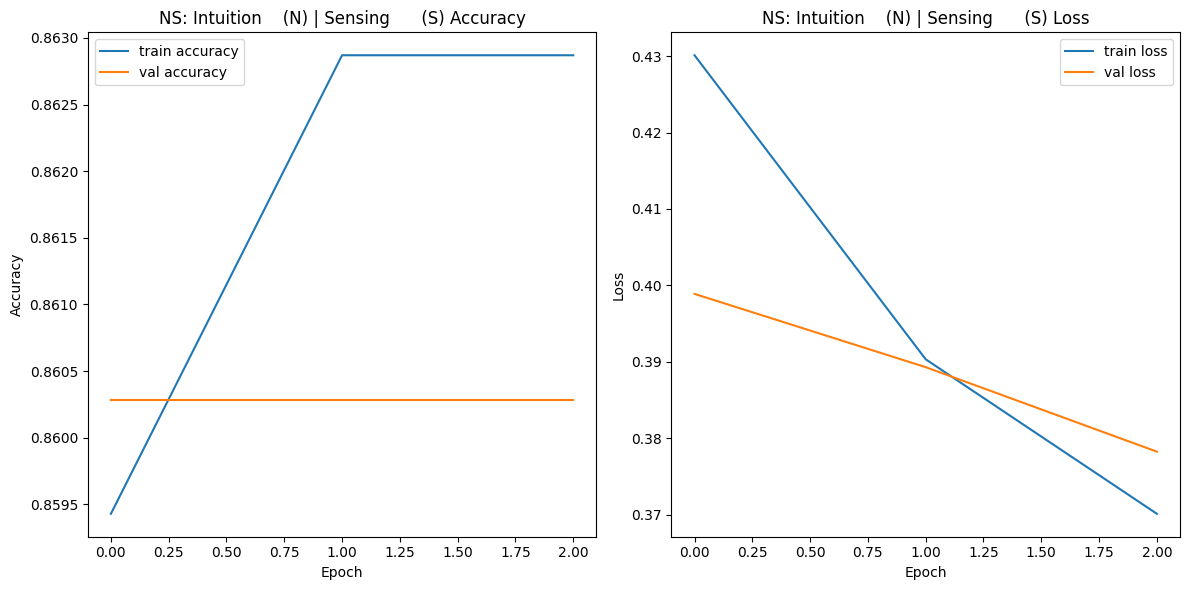



Epoch 1/3
182/182 [==============================] - 1s 4ms/step - loss: 0.6675 - accuracy: 0.5793 - val_loss: 0.5943 - val_accuracy: 0.6940
Epoch 2/3
182/182 [==============================] - 1s 4ms/step - loss: 0.5619 - accuracy: 0.7065 - val_loss: 0.5496 - val_accuracy: 0.7244
Epoch 3/3
90/90 [==============================] - 0s 1ms/step
FT: Feeling      (F) | Thinking     (T) Accuracy: 71.92%
FT: Feeling      (F) | Thinking     (T) Classification report for Train Data
182/182 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3140
           1       0.80      0.73      0.76      2672

    accuracy                           0.79      5812
   macro avg       0.79      0.79      0.79      5812
weighted avg       0.79      0.79      0.79      5812

FT: Feeling      (F) | Thinking     (T) Classification report for Test Data
              precision    recall  f1-score   support

      

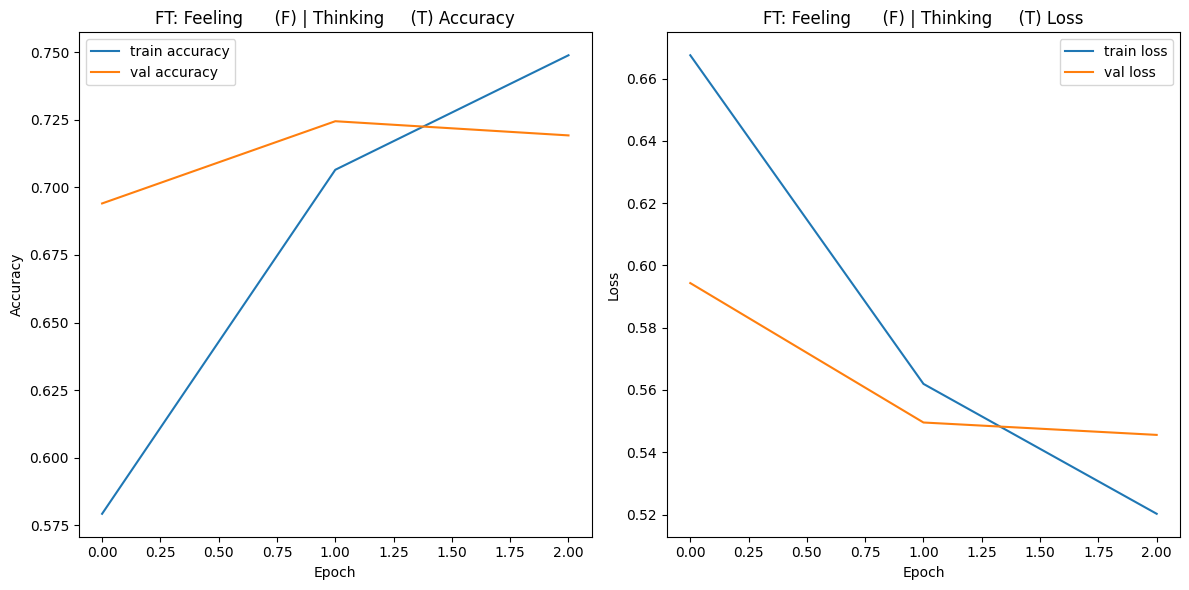



Epoch 1/3
182/182 [==============================] - 1s 5ms/step - loss: 0.6726 - accuracy: 0.6012 - val_loss: 0.6682 - val_accuracy: 0.6092
Epoch 2/3
182/182 [==============================] - 1s 4ms/step - loss: 0.6546 - accuracy: 0.6110 - val_loss: 0.6392 - val_accuracy: 0.6441
Epoch 3/3
90/90 [==============================] - 0s 1ms/step
JP: Judging      (J) | Perceiving   (P) Accuracy: 64.41%
JP: Judging      (J) | Perceiving   (P) Classification report for Train Data
182/182 [==============================] - 0s 906us/step
              precision    recall  f1-score   support

           0       0.73      0.34      0.46      2315
           1       0.68      0.92      0.78      3497

    accuracy                           0.69      5812
   macro avg       0.70      0.63      0.62      5812
weighted avg       0.70      0.69      0.65      5812

JP: Judging      (J) | Perceiving   (P) Classification report for Test Data
              precision    recall  f1-score   support

    

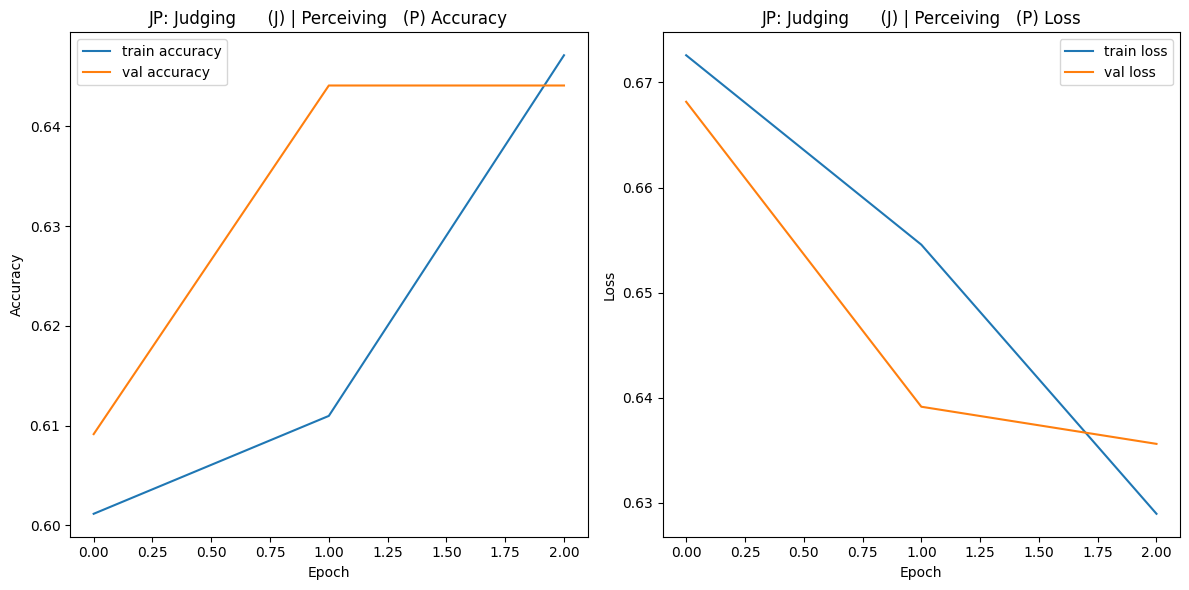

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# 用于记录训练过程中的准确率和损失
history = {}

# 设置最大训练次数
epochs = 3  # 将训练次数设置为 5

# EarlyStopping 设置（监控验证集的损失，耐心为 2，表示验证集损失不再减小时最多等待 2 次）
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # 创建一个简单的神经网络模型
    model = Sequential()
    
    # 输入层（假设输入特征 X 的维度为 100）
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))  # 添加 Dropout 层，防止过拟合
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # 添加 Dropout 层，防止过拟合
    model.add(Dense(32, activation='relu'))
    
    # 输出层：对于二分类问题（MBTI 每个类型是一个二分类问题）
    model.add(Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # 训练模型，加入 EarlyStopping
    history[l] = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), 
                           verbose=1, callbacks=[early_stopping])
    
    # 使用模型进行预测
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 将概率转换为0或1
    
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    
    # 打印训练和测试集的分类报告
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train, model.predict(X_train) > 0.5))
    
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    
    # 绘制训练和验证的损失、准确率曲线
    plt.figure(figsize=(12, 6))

    # 绘制训练和验证的准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(history[l].history['accuracy'], label='train accuracy')
    plt.plot(history[l].history['val_accuracy'], label='val accuracy')
    plt.title(f'{personality_type[l]} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制训练和验证的损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(history[l].history['loss'], label='train loss')
    plt.plot(history[l].history['val_loss'], label='val loss')
    plt.title(f'{personality_type[l]} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 显示图像
    plt.tight_layout()
    plt.show()

    print("\n")
